In [1]:
import os
import re
import time
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap
import hdbscan

os.environ['XDG_CACHE_HOME'] = 'home/msds2022/casoriano/ .cache'

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vuboakbp because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Abstract Preprocessing

In [2]:
df = pd.read_excel('research_profile_v1.xlsx').drop([112, 167, 638, 648, 663, 787, 1138, 1204])
docs = df['Abstract'].copy().dropna().reset_index(drop=True)

length = docs.str.split(' ').apply(lambda x: np.log(len(x)))
docs = docs[abs((length - length.mean())/length.std()) < 3].reset_index(drop=True)
docs = docs.apply(lambda x: re.sub(r'[^a-zA-Z0-9- ]', '', x)).str.lower()

docs.head()

0    the ched phernet-admu program has been conduct...
1    the warm tropical climate of the philippines a...
2    the study was conducted to determine the green...
3    this study aimed to establish a solid waste ma...
4    farming systems refers to the utilization of t...
Name: Abstract, dtype: object

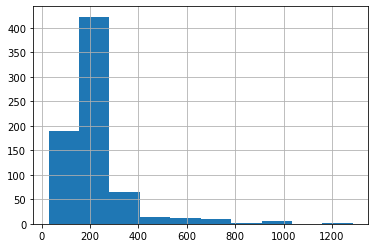

In [4]:
docs.str.split(' ').apply(lambda x: len(x)).hist();

### Document Embeddings

In [5]:
model = SentenceTransformer('allenai/scibert_scivocab_uncased')
model.max_seq_length = 512

Some weights of the model checkpoint at home/msds2022/casoriano/ .cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
start = time.time()
embeddings = model.encode(docs.tolist(), convert_to_tensor=True)
print("Time for computing embeddings:", time.time()-start)
embeddings = pd.DataFrame(embeddings.cpu().numpy())
embeddings

Time for computing embeddings: 9.498752117156982


0         1         2         3         4         5         6    \
0    0.181351 -0.082515  0.048685  0.642390  0.074122  0.023601  0.080963   
1    0.172642 -0.474830  0.071287  0.748413  0.417740 -0.559243  0.224872   
2   -0.167316 -0.138807 -0.018633  0.301282  0.390821 -0.356393 -0.247679   
3   -0.113860 -0.041213  0.079641  0.343612  0.484763 -0.247096 -0.036519   
4   -0.144146 -0.168748 -0.192976  0.652894  0.840897 -0.339490 -0.333297   
..        ...       ...       ...       ...       ...       ...       ...   
711  0.109650 -0.243478  0.018300  0.660380  0.490989 -0.420348 -0.182406   
712  0.218530 -0.295555 -0.216086  0.451090  0.243877 -0.230475 -0.146155   
713 -0.132586 -0.217568 -0.216702  0.598328  0.380021 -0.317951 -0.167109   
714 -0.117475  0.397458 -0.244951  0.496243  0.299950 -0.382393  0.070458   
715  0.093074 -0.074846  0.061127  0.713001  0.133621 -0.380525  0.343353   

          7         8         9    ...       758       759       760  \
0    0.289377 -0.311528  0.069098  ...  0.036283 -0.383556  0.358726   
1    0.310863 -0.050578  0.508311  ... -0.025646 -0.050801  0.484620   
2    0.274972 -0.210722  0.382693  ... -0.445453  0.354673  0.910121   
3    0.357647 -0.260173  0.302504  ... -0.307838  0.312670  0.656381   
4    0.313039 -0.272664  0.328918  ... -0.015351  0.280139  0.665878   
..        ...       ...       ...  ...       ...       ...       ...   
711  0.333824 -0.219407  0.351254  ... -0.097456 -0.156980  0.254438   
712  0.723723 -0.324037  0.124667  ...  0.029086 -0.202334  0.657260   
713  0.431046 -0.210011  0.200793  ...  0.078332 -0.270864  0.523251   
714  0.429284 -0.171597  0.035465  ... -0.031396 -0.653766  0.022912   
715  0.217134 -0.372111  0.098302  ... -0.039036 -0.320138  0.247614   

          761       762       763       764       765       766       767  
0   -0.258438 -0.076697  0.047899 -0.460318 -0.150287 -0.070753 -0.901719  
1   -0.327638 -0.274964  0.523232 -0.484853 -0.295440  0.007945 -0.373034  
2   -0.178316  0.076794  0.510888 -0.554893 -0.061503  0.147558 -0.671171  
3   -0.422247  0.126761  0.434780 -0.322191 -0.028502 -0.072984 -0.967157  
4   -0.629267 -0.287759  0.369765 -0.489733 -0.240963  0.062522 -0.685168  
..        ...       ...       ...       ...       ...       ...       ...  
711 -0.562201 -0.562341  0.243686 -0.745007 -0.197280  0.473074 -0.589212  
712 -0.365573 -0.400090  0.445309 -0.405671 -0.147562  0.184796 -0.533516  
713 -0.351327 -0.552934  0.348681 -0.501709 -0.044519  0.314308 -0.513044  
714 -0.411320 -0.041796  0.286902 -0.457902 -0.168661  0.227504 -0.830705  
715 -0.437724 -0.460437  0.242856 -0.389198 -0.216756  0.121055 -0.915041  

[716 rows x 768 columns]

### Clustering

#### kmeans

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

inertias = []
ci_scores = []
silh_scores = []
db_scores = []
for k in range(2, 21):
    clusterer = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    labels = clusterer.labels_
    inertias.append(clusterer.inertia_)
    ci_scores.append(calinski_harabasz_score(embeddings, labels))
    silh_scores.append(silhouette_score(embeddings, labels, metric='cosine'))
    db_scores.append(davies_bouldin_score(embeddings, labels))

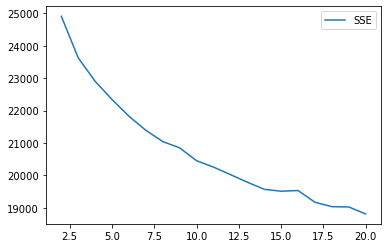

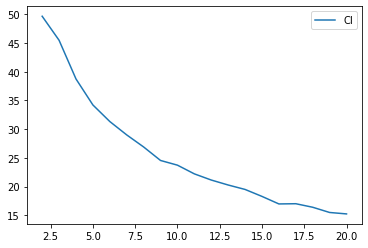

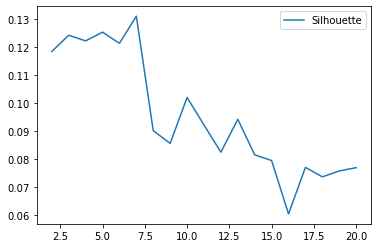

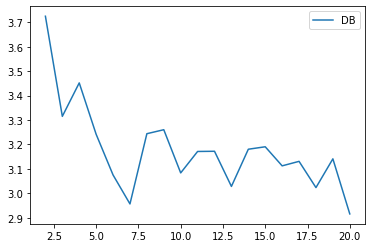

In [15]:
plt.plot(range(2, 21), inertias, label='SSE')
plt.legend()
plt.show()
plt.plot(range(2, 21), ci_scores, label='CI')
plt.legend()
plt.show()
plt.plot(range(2, 21), silh_scores, label='Silhouette')
plt.legend()
plt.show()
plt.plot(range(2, 21), db_scores, label='DB')
plt.legend()
plt.show()

#### DBSCAN

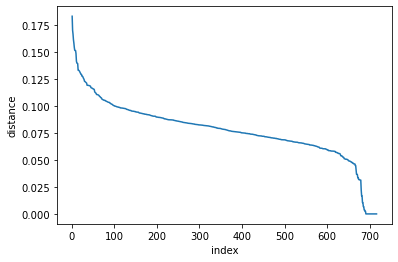

In [17]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, metric='cosine').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

dist_desc = sorted(distances[:,-1], reverse=True)
plt.plot(list(range(1,len(dist_desc)+1)), dist_desc)
plt.xlabel("index")
plt.ylabel("distance")
plt.show()

In [18]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.120, min_samples=2, metric='cosine', n_jobs=-1).fit(embeddings)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 3
Estimated number of noise points: 35
CI Coefficient: 5.25463
Silhouette Coefficient: 0.07762
DB Coefficient: 3.67182


#### Agglomerative Clustering - Complete

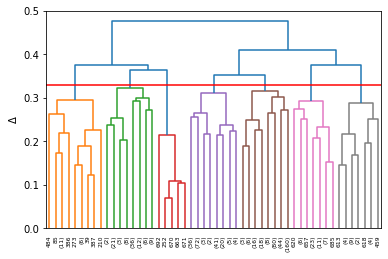

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_tree(Z, ylabel='$\Delta$'):
    fig, ax = plt.subplots()
    dn = dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_ylabel(f'{ylabel}')

Z = linkage(embeddings, method='complete', metric='cosine', optimal_ordering=True)
plot_tree(Z)
plt.axhline(0.33, color='red')
plt.show()

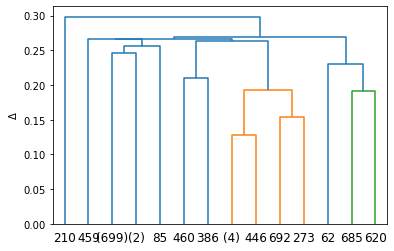

In [20]:
Z = linkage(embeddings, method='average', metric='cosine', optimal_ordering=True)
plot_tree(Z)

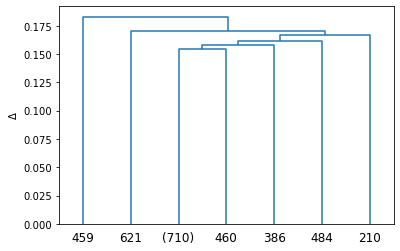

In [21]:
Z = linkage(embeddings, method='single', metric='cosine', optimal_ordering=True)
plot_tree(Z)

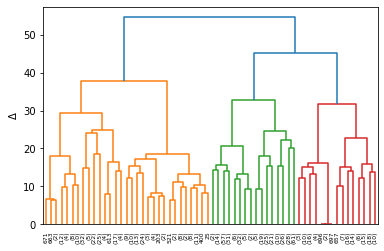

In [22]:
Z = linkage(embeddings, method='ward', metric='euclidean', optimal_ordering=True)
plot_tree(Z)

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

Z = linkage(embeddings, method='complete', metric='cosine', optimal_ordering=True)
labels = fcluster(Z, t=0.33, criterion='distance')

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 7
Estimated number of noise points: 0
CI Coefficient: 14.75859
Silhouette Coefficient: 0.02380
DB Coefficient: 3.74997


#### Spectral Co-Clustering

In [25]:
from sklearn.cluster import SpectralCoclustering

scoring = ['run_time', 'CI Coefficient', 'Silhouette Coefficient', 'DB Coefficient']
results = pd.DataFrame(columns=scoring)
for i in range(2, 21):
    start_time = time.time()
    scc = SpectralCoclustering(n_clusters=i, svd_method='arpack', random_state=42).fit(embeddings)
    labels = scc.row_labels_
    results.loc[i] = {"run_time": time.time() - start_time,
                                    'CI Coefficient': calinski_harabasz_score(embeddings, labels),
                                    'Silhouette Coefficient': silhouette_score(embeddings, labels),
                                    'DB Coefficient': davies_bouldin_score(embeddings, labels)}
results

run_time  CI Coefficient  Silhouette Coefficient  DB Coefficient
2   0.095593       24.399561                0.033047        5.332490
3   0.432549       31.395292                0.033718        5.080840
4   0.530364       24.715913                0.024601        5.346392
5   0.453813       29.484854                0.036304        4.097890
6   0.478158       25.672572                0.029652        4.233794
7   0.486811       22.389588                0.021950        4.430409
8   0.483459       20.437333                0.021666        4.275405
9   0.538117       20.162680                0.027419        4.143799
10  0.585885       18.551256                0.019224        4.203103
11  0.513455       18.777226                0.019154        4.150026
12  0.597558       16.082609                0.020027        4.154363
13  0.552815       16.386667                0.018087        4.104231
14  0.605642       15.657991                0.022016        3.995084
15  0.664258       14.050209                0.017131        3.884390
16  0.688124       13.536353                0.015661        3.984867
17  0.655537       14.227598                0.020304        3.747665
18  0.659552       13.614683                0.017593        3.697230
19  0.762716       13.365568                0.020066        3.689059
20  0.781809       12.648406                0.008284        3.550129

<AxesSubplot:>

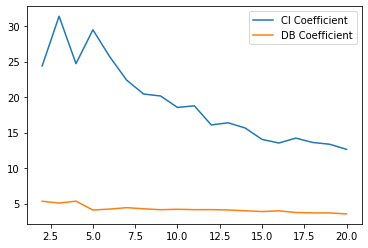

In [27]:
results[['CI Coefficient', 'DB Coefficient']].plot()

#### HDBSCAN w/o UMAP

In [16]:
from sklearn.metrics.pairwise import cosine_distances

cos_dist = cosine_distances(embeddings).astype('double')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                          min_samples=2,
                          metric='precomputed').fit(cos_dist)
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 3
Estimated number of noise points: 563
CI Coefficient: 11.10711
Silhouette Coefficient: -0.07908
DB Coefficient: 3.69437


#### HDBSCAN w/ UMAP

In [121]:
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

In [122]:
temp = umap.UMAP(n_neighbors=20, n_components=2, metric='cosine').fit_transform(embeddings)

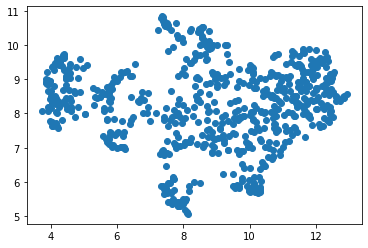

In [123]:
result = pd.DataFrame(temp, columns=['x', 'y'])

plt.scatter(result.x, result.y);

In [126]:
results = []

for i in range(2, 21):
    for j in range(2, 21):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i,
                                    min_samples=j,
                                    metric='euclidean').fit(umap_embeddings)
        labels = clusterer.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        results.append([i, j, n_clusters_, n_noise_,
                        calinski_harabasz_score(umap_embeddings, labels),
                        silhouette_score(umap_embeddings, labels),
                        davies_bouldin_score(umap_embeddings, labels)])

In [127]:
temp = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'clusters',
                                      'noise', 'CI', 'Silh', 'DB'])
temp[(temp['clusters'] < 20) & (temp['clusters'] > 6)].sort_values(['noise', 'CI', 'Silh', 'DB'], ascending=[True, False, False, True])

min_cluster_size  min_samples  clusters  noise          CI      Silh  \
286                17            3        12    158  335.675097  0.266535   
305                18            3        12    158  335.675097  0.266535   
267                16            3        13    173  321.047999  0.253363   
342                20            2        14    184  314.613214  0.226770   
326                19            5        11    188  286.395433  0.236700   
..                ...          ...       ...    ...         ...       ...   
280                16           16         9    334  176.038513  0.082179   
299                17           16         9    334  176.038513  0.082179   
33                  3           16        12    339  133.432392  0.007347   
52                  4           16        12    339  133.432392  0.007347   
71                  5           16        12    339  133.432392  0.007347   

           DB  
286  1.368163  
305  1.368163  
267  1.222996  
342  1.233490  
326  1.360697  
..        ...  
280  1.329785  
299  1.329785  
33   1.299830  
52   1.299830  
71   1.299830  

[254 rows x 7 columns]

### c-TF-IDF

In [159]:
docs_df = pd.DataFrame(docs.tolist(), columns=["Doc"])
docs_df['Topic'] = labels
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [163]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 6)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs.tolist()))

In [164]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
# topic_sizes['Names'] = ['Outliers', 'EDUCATION', 'DATA SCIENCE / TECHNOLOGY',
#                         'GOVERNANCE / POLICY', 'COVID19 PANDEMIC', 'IPS / HISTORY',
#                         'AGRICULTURE / YIELD', 'MICROBIOLOGY', 'BOTANY / MARINE BIOLOGY',
#                         'NUTRITION']
topic_sizes

Topic  Size
6       7   165
2       3    98
9      10    70
4       5    67
10     11    65
5       6    64
1       2    55
8       9    47
7       8    34
0       1    26
3       4    25

In [175]:
print('EDUCATION')
top_n_words[7]

EDUCATION


[('skills', 0.0015277360115963105),
 ('mathematics', 0.0014499591101786093),
 ('teachers', 0.0014492915674128107),
 ('teaching', 0.0014128867485484837),
 ('school', 0.0012976030681524878),
 ('level', 0.001294414605417509),
 ('performance', 0.0012165872982043632),
 ('relationship', 0.001213738830391135),
 ('academic', 0.0011770747165806244),
 ('graduates', 0.0011739330825448144),
 ('respondents', 0.0011491608591160459),
 ('teacher', 0.0010779050415001658),
 ('self', 0.0010311126782372542),
 ('satisfaction', 0.0010285725364286046),
 ('student', 0.0010231367418612324),
 ('academic performance', 0.0010022007056343396),
 ('state', 0.0009899805121625488),
 ('science', 0.0009882775891107045),
 ('high school', 0.0009786963393765282),
 ('mean', 0.0009440393130590955)]

In [180]:
print('AGRICULTURE YIELD')
top_n_words[3]

AGRICULTURE YIELD


[('yield', 0.002102165430071601),
 ('weight', 0.002072094293207206),
 ('treatments', 0.0019705725783650506),
 ('treatment', 0.0015570676694412076),
 ('rice', 0.0015125827383347845),
 ('highest', 0.001439090268449257),
 ('acceptability', 0.0014280550168679841),
 ('drying', 0.0013985513420749077),
 ('seeds', 0.00138446035580459),
 ('randomized', 0.001379530721582164),
 ('banana', 0.0013567802673287858),
 ('feed', 0.0013531518706493427),
 ('varieties', 0.0013424068397591726),
 ('days', 0.0013379707188912791),
 ('dried', 0.0012627016862195696),
 ('soil', 0.0012532895326050025),
 ('sensory', 0.0012316143816712758),
 ('color', 0.0012258456389202437),
 ('egg', 0.0011807165563600145),
 ('length', 0.0011781453889160869)]

In [181]:
print('GOVERNMENT')
top_n_words[10]

GOVERNMENT


[('government', 0.002192158788810809),
 ('economic', 0.0018175195447891921),
 ('community', 0.0017010898089180311),
 ('sustainable', 0.0015663135799271546),
 ('farmers', 0.0015356691973652768),
 ('local', 0.001520140786005993),
 ('climate', 0.001439919103563701),
 ('development', 0.001415613688160073),
 ('communities', 0.0014040790162603708),
 ('practices', 0.0013824263692265022),
 ('water', 0.0013775580396467133),
 ('program', 0.0013725573771698801),
 ('pes', 0.0013403471367335429),
 ('health', 0.001321124178743334),
 ('barmm', 0.0012029060896865042),
 ('climate change', 0.001188328273771763),
 ('local government', 0.0011756894732403227),
 ('change', 0.0011483216420599513),
 ('ip', 0.0011325458118337085),
 ('tourism', 0.00112542824805375)]

In [183]:
print('DATA SCIENCE')
top_n_words[5]

DATA SCIENCE


[('algorithm', 0.0017762050309509533),
 ('image', 0.0017514224480708134),
 ('accuracy', 0.0016581969967341952),
 ('password', 0.001443159050000835),
 ('encryption', 0.001443159050000835),
 ('images', 0.0013478801632724258),
 ('model', 0.0013186377461004936),
 ('classification', 0.0013141915363553557),
 ('energy', 0.0012916955443758287),
 ('users', 0.0012615301672353303),
 ('machine', 0.0012531744799898715),
 ('power', 0.0011676149653805422),
 ('algorithms', 0.0011563095401093994),
 ('classifier', 0.0011528582432941005),
 ('room', 0.0010933125238909807),
 ('feature', 0.0010633803526321941),
 ('signal', 0.0010517400128954952),
 ('training', 0.001028254890220613),
 ('user', 0.0010176039608166766),
 ('models', 0.0010133367038840631)]

In [185]:
print('PANDEMIC')
top_n_words[11]

PANDEMIC


[('face', 0.0018943367464429445),
 ('shall', 0.0017049028519430646),
 ('project', 0.001697549686623918),
 ('distribution', 0.0015891115783607224),
 ('products', 0.0014139996228930338),
 ('soap', 0.0014054567728769038),
 ('product', 0.001385432226685677),
 ('masks', 0.001366457991111631),
 ('production', 0.0012530705825884668),
 ('face masks', 0.0012049745382921326),
 ('mask', 0.0011560645942682922),
 ('alcohol', 0.0010539834588643767),
 ('produced', 0.0010464477441666862),
 ('hand', 0.0010158070740466881),
 ('fisheries', 0.0009748469643019776),
 ('nutri', 0.0009706989767649193),
 ('beneficiaries', 0.0009681494327413601),
 ('chip', 0.0009574621818628094),
 ('materials', 0.0009539822724433093),
 ('fruit', 0.0009458668265996622)]

In [187]:
print('ONLINE LEARNING')
top_n_words[6]

ONLINE LEARNING


[('internet', 0.0020676330575443696),
 ('steam', 0.0017727069824572672),
 ('connection', 0.0016868234169038782),
 ('internet connection', 0.001581059758282668),
 ('bullying', 0.0015390689299463883),
 ('experiences', 0.001480096743416043),
 ('online', 0.0014223167304147797),
 ('election', 0.001394026008706775),
 ('learning', 0.001336934780733892),
 ('education', 0.0013278150166319191),
 ('pandemic', 0.0013241466266956747),
 ('participants', 0.0012803678197115945),
 ('challenges', 0.0012336682934377177),
 ('flexible learning', 0.001194264825302155),
 ('work', 0.0011871304371760308),
 ('classes', 0.0011709474030781627),
 ('respondents', 0.0011641727190835074),
 ('employees', 0.0011186377840805665),
 ('flexible', 0.0011100210935841802),
 ('life', 0.0011088734905117259)]

In [193]:
print('MICROBIOLOGY / BOTANY')
top_n_words[2][:15]

MICROBIOLOGY / BOTANY


[('salt', 0.0021689892521764716),
 ('plant', 0.001981968810818019),
 ('bacterial', 0.0018421144070861612),
 ('bacteria', 0.0018172647793571045),
 ('isolates', 0.0016806938293840957),
 ('stress', 0.0016093097879909973),
 ('rice', 0.0016031957212784772),
 ('plant growth', 0.001397620662197721),
 ('potential', 0.001375576839878627),
 ('emission', 0.0013543130999662573),
 ('optical', 0.0012696685312183664),
 ('species', 0.0012341229921691915),
 ('growth', 0.00120307208607922),
 ('endophytes', 0.0011975985412728582),
 ('nanoparticles', 0.0011275487120779443)]

In [195]:
print('INDIGENOUS PEOPLE')
top_n_words[9][:15]

INDIGENOUS PEOPLE


[('cultural', 0.0032144316128052152),
 ('indigenous', 0.0028191173062465623),
 ('humor', 0.0022373133266919984),
 ('oral', 0.001856108720684852),
 ('paper', 0.0018405759292190174),
 ('culture', 0.0017818560547444976),
 ('dutertes', 0.00177233606651175),
 ('discourse', 0.0016479897650062121),
 ('tinguian', 0.0016406964395741324),
 ('identity', 0.0016406964395741324),
 ('philosophy', 0.0016112146059197728),
 ('tradition', 0.0014831907885055908),
 ('regional', 0.0014211939688484319),
 ('igorot', 0.0013872712506172195),
 ('textual', 0.0013509142538486482)]

In [197]:
print('AGRICULTURE')
top_n_words[8][:15]

AGRICULTURE


[('crops', 0.0021947185077629567),
 ('farm', 0.0021665480045680073),
 ('biodiversity', 0.002021150261234202),
 ('adoption', 0.0019747322294156764),
 ('farming', 0.0019359171457477297),
 ('farmers', 0.001859326376751294),
 ('women', 0.0017466282406808575),
 ('climate', 0.0017384290816686652),
 ('tubers', 0.0016294065387421333),
 ('food', 0.0016130257977746342),
 ('public', 0.0015777734459746402),
 ('yam', 0.0015473300271588593),
 ('household', 0.001541142565306639),
 ('traditional', 0.0015283556413797866),
 ('peanut', 0.0015128011064602669)]

In [199]:
print('MARINE BIOLOGY')
top_n_words[1][:15]

MARINE BIOLOGY


[('species', 0.007029170419403452),
 ('reef', 0.004396746368411423),
 ('island', 0.0038317994239855124),
 ('diversity', 0.003537180032109197),
 ('giant', 0.0034840593997954696),
 ('fish', 0.003296540987091988),
 ('samal', 0.0032643387652917036),
 ('coral', 0.003209839085222821),
 ('seagrass', 0.003101093268188674),
 ('habitats', 0.002903018506271617),
 ('fishes', 0.002819978072830781),
 ('fishing', 0.0026560904937974815),
 ('reef fishes', 0.002585916446308902),
 ('samal island', 0.002585916446308902),
 ('abundance', 0.002301848514987697)]

In [200]:
print('DATA SCIENCE')
top_n_words[4][:15]

DATA SCIENCE


[('delay', 0.005025405862115775),
 ('equations', 0.004397230129351303),
 ('stability', 0.004240961408210749),
 ('numerical', 0.004213710990139953),
 ('predator', 0.004183958574748167),
 ('algorithm', 0.004044232262133845),
 ('differential', 0.0040232058873816545),
 ('model', 0.003931254961747292),
 ('solutions', 0.003869758607913037),
 ('desa', 0.0036421037554076915),
 ('derivatives', 0.0036421037554076915),
 ('equilibrium', 0.0036421037554076915),
 ('prey', 0.0036421037554076915),
 ('symmetry', 0.003625985300967237),
 ('fluid', 0.003358753330486897)]